In [1]:
from datasets import Dataset, Audio, DatasetDict,load_dataset ,concatenate_datasets
from torch.utils.data import DataLoader
import pandas as pd
import os

# Define paths
dataset_dir = "/home/hkngae/COMP5412/data/NoisySpeechDataset"
demand_dir = "/home/hkngae/COMP5412/data/local_datasets"
metadata_file = os.path.join(dataset_dir, "metadata.csv")
first_n = 8000  # Number of examples to load for trial
demand_ds = load_dataset("JacobLinCool/VoiceBank-DEMAND-16k", cache_dir=demand_dir)

### Dataset demand_ds contains: ['train', 'test']
### Split 'train' contains 11572 examples
### Features: {'id': Value(dtype='string', id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}
### Split 'test' contains 824 examples
### Features: {'id': Value(dtype='string', id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}



# Check if metadata file exists and read its structure first
if os.path.exists(metadata_file):
    # Just peek at the first few rows to see the structure
    print("Metadata file columns:")
    print(pd.read_csv(metadata_file, nrows=1).columns.tolist())

    # Load only the first n examples from metadata for trial
    metadata_df = pd.read_csv(metadata_file).head(first_n)

    # Assuming columns like "noisy_file", "clean_file", "snr" exist
    # Adapt these column names to match your actual metadata structure
    dataset_dict = {
        "id": [str(i) for i in range(len(metadata_df))],
        "noisy": metadata_df["noisy_file"].tolist() if "noisy_file" in metadata_df.columns else [],
        "clean": metadata_df["clean_file"].tolist() if "clean_file" in metadata_df.columns else [],
        #"snr": metadata_df["snr"].tolist() if "snr" in metadata_df.columns else []
    }
    
    # Create the dataset
    small_ds = Dataset.from_dict(dataset_dict)
    
    # Add audio loading functionality 
    if "noisy_file" in metadata_df.columns:
        small_ds = small_ds.cast_column("noisy", Audio(sampling_rate=16000))
    if "clean_file" in metadata_df.columns:
        small_ds = small_ds.cast_column("clean", Audio(sampling_rate=16000))
    
    # Inspect the small dataset
    print(f"Small dataset contains {len(small_ds)} examples")
    print(f"Features: {small_ds.features}")
    print(demand_ds["train"].features)
    #concat with demand_ds['train']
    combined_ds = DatasetDict({
        'custom': small_ds,
        'train': demand_ds['train'],
        'test': demand_ds['test']
        })
    full_ds = concatenate_datasets([combined_ds['train'], combined_ds['test'], combined_ds['custom']])

    print(f"\nCombined dataset size: {len(full_ds)} examples")
    print(f"Combined dataset features: {full_ds.features}")

    
else:
    print(f"Metadata file not found at {metadata_file}")
    print("Please check the path or create the metadata file.")

/home/hkngae/anaconda3/envs/COMP5412/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Metadata file columns:
['noisy_file', 'clean_file', 'noise_file', 'snr']
Small dataset contains 8000 examples
Features: {'id': Value(dtype='string', id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}
{'id': Value(dtype='string', id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}

Combined dataset size: 20396 examples
Combined dataset features: {'id': Value(dtype='string', id=None), 'clean': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'noisy': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}


In [2]:
# Add a cell to examine and listen to examples from the full_ds
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import numpy as np



--- Sample 1 (Index 120) ---
ID: p226_126
Noisy audio: 39852 samples, 2.49 seconds, 16000 Hz


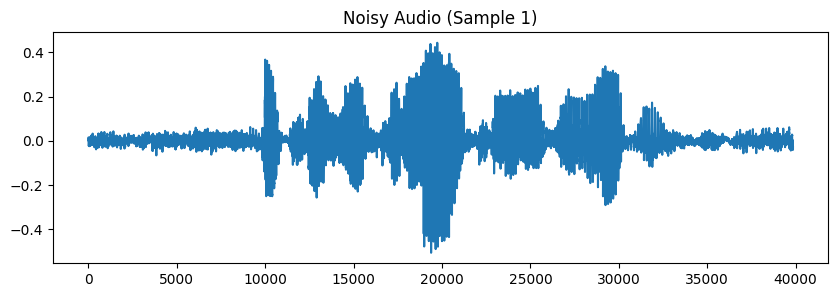

Noisy Audio:


Clean audio: 39852 samples, 2.49 seconds, 16000 Hz


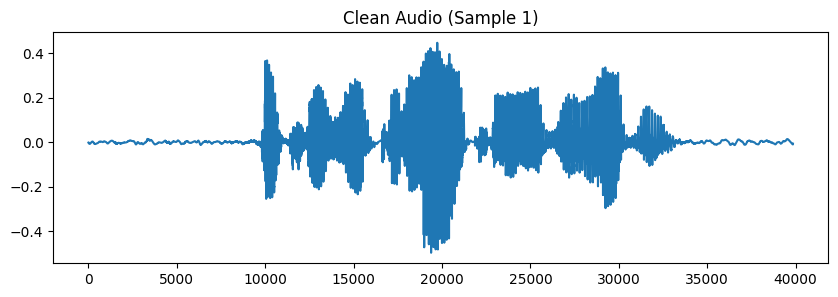

Clean Audio:



--- Sample 2 (Index 11918) ---
ID: p232_364
Noisy audio: 39540 samples, 2.47 seconds, 16000 Hz


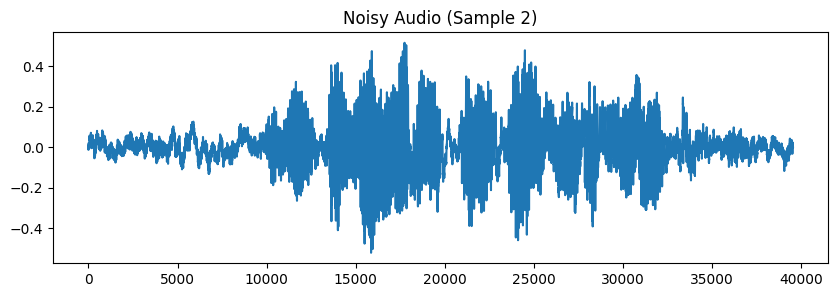

Noisy Audio:


Clean audio: 39540 samples, 2.47 seconds, 16000 Hz


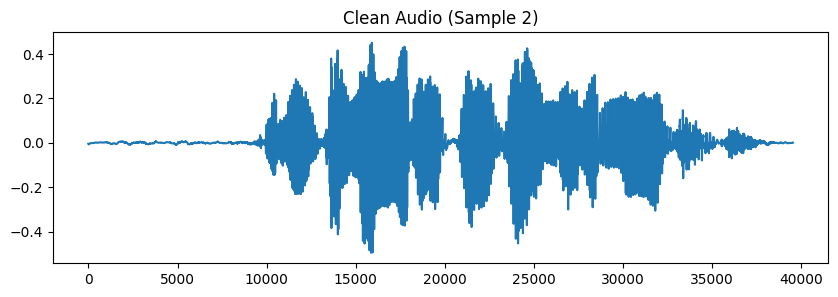

Clean Audio:


In [3]:


def examine_audio_samples(dataset, num_samples=2):
    """
    Examine and listen to random samples from a dataset.
    """
    # Get random indices to sample from different parts of the dataset
    total_samples = len(dataset)
    
    # Try to get samples from different parts of the dataset
    # (likely from custom, train, and test portions)
    sample_indices = [
        np.random.randint(0, min(1000, total_samples//3)),  # First third (likely custom data)
        np.random.randint(total_samples//3, 2*total_samples//3),  # Middle third (likely train data)
        np.random.randint(2*total_samples//3, total_samples)  # Last third (likely test data)
    ][:num_samples]
    
    for i, idx in enumerate(sample_indices):
        sample = dataset[idx]
        
        print(f"\n--- Sample {i+1} (Index {idx}) ---")
        print(f"ID: {sample['id']}")
        
        # Display and play noisy audio
        if "noisy" in sample:
            noisy_audio = sample["noisy"]["array"]
            sr = sample["noisy"]["sampling_rate"]
            duration = len(noisy_audio)/sr
            print(f"Noisy audio: {len(noisy_audio)} samples, {duration:.2f} seconds, {sr} Hz")
            
            # Plot waveform
            plt.figure(figsize=(10, 3))
            plt.plot(noisy_audio)
            plt.title(f"Noisy Audio (Sample {i+1})")
            plt.show()
            
            # Play audio
            print("Noisy Audio:")
            display(Audio(noisy_audio, rate=sr))
        
        # Display and play clean audio
        if "clean" in sample:
            clean_audio = sample["clean"]["array"]
            sr = sample["clean"]["sampling_rate"]
            duration = len(clean_audio)/sr
            print(f"Clean audio: {len(clean_audio)} samples, {duration:.2f} seconds, {sr} Hz")
            
            # Plot waveform
            plt.figure(figsize=(10, 3))
            plt.plot(clean_audio)
            plt.title(f"Clean Audio (Sample {i+1})")
            plt.show()
            
            # Play audio
            print("Clean Audio:")
            display(Audio(clean_audio, rate=sr))


examine_audio_samples(full_ds, num_samples=2)

In [4]:
fixed_length_in=64105
fixed_length_out = 64007   

In [5]:
from mydatasets.rawAudioDenoisingDataset import RawAudioDenoisingDataset

train_ds,test_ds = full_ds.train_test_split(test_size=0.2).values()
train_ds,val_ds = train_ds.train_test_split(test_size=0.25).values()

# Set a fixed length for training (e.g., 2 seconds of audio at 16kHz = 32000 samples)
# Or set to None to keep variable 
#  with padding in batches
 # Use a fixed length like this
#fixed_length_in=50137
#fixed_length_out = 48009    # Use a fixed length like this

# Create datasets
train_dataset = RawAudioDenoisingDataset(train_ds, fixed_length=None, input_length=fixed_length_in, output_length=fixed_length_out, augment=True)
val_dataset = RawAudioDenoisingDataset(val_ds, fixed_length=None, input_length=fixed_length_in, output_length=fixed_length_out,)
test_dataset = RawAudioDenoisingDataset(test_ds, fixed_length=None, input_length=fixed_length_in, output_length=fixed_length_out,)

# Create data loaders
batch_size = 32
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    collate_fn=RawAudioDenoisingDataset.variable_length_collate if fixed_length_out is None else None
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    collate_fn=RawAudioDenoisingDataset.variable_length_collate if fixed_length_out is None else None
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    collate_fn=RawAudioDenoisingDataset.variable_length_collate if fixed_length_out is None else None
)

# Verify a batch
for batch in train_loader:
    print(f"Noisy audio shape: {batch['noisy'].shape}")
    print(f"Clean audio shape: {batch['clean'].shape}")
    print(f"Noise audio shape: {batch['noise'].shape}")
    if fixed_length_in is None:
        print(f"Sequence lengths: {batch['lengths']}")
    break

Noisy audio shape: torch.Size([32, 64105])
Clean audio shape: torch.Size([32, 64007])
Noise audio shape: torch.Size([32, 64007])


In [6]:
from models.myModel.my_model import InceptionFCN
import importlib
import models.Inception.waveunet
importlib.reload(models.Inception.waveunet)
from models.Inception.waveunet import Waveunet
from torch import nn
from training.ddp_trainer import run_ddp_training
import torch.multiprocessing as mp
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils.snr import calculate_snr
from utils.pesq import calculate_pesq
from utils.stoi import calculate_stoi
from torchsummary import summary



In [7]:

def test_model(model, test_loader, criterion=None, save_examples=True, num_examples=2):
    """
    Test the denoising model and compute metrics
    
    Args:
        model: The trained model
        test_loader: DataLoader for test data
        criterion: Loss function (optional)
        save_examples: Whether to save example denoised files
        num_examples: Number of examples to visualize and save
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    test_loss = 0.0
    all_snr_before = []
    all_snr_after = []
    all_pesq_before=[]
    all_pesq_after=[]
    all_stoi_before=[]
    all_stoi_after=[]
    examples = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            noisy = batch['noisy'].unsqueeze(1).to(device)  # Add channel dimension
            clean = batch['clean'].unsqueeze(1).to(device)  # Add channel dimension
            noise = batch['noise'].unsqueeze(1).to(device)
            mask = batch['mask'].unsqueeze(1).to(device)  # Add channel dimension
            
            # Forward pass
            #print(noisy.shape)
            denoised = model(noisy)
            output_clean,output_noise = denoised["speech"], denoised["noise"]
            
            # Store some examples
            if i < num_examples:
                examples.append({
                    'noisy': noisy[0].cpu().numpy().flatten(),
                    'clean': clean[0].cpu().numpy().flatten(),
                    'denoised': denoised["speech"][0].cpu().numpy().flatten()
                })
            
            # Calculate metrics
            loss = 0
            element_l1 = criterion[1](output_clean, clean)
            noise_l1 = criterion[1](output_noise, noise)
            masked_l1 = ((element_l1 * mask).sum() + (noise_l1 * mask).sum()) / (mask.sum() + 1e-8)
            
            # Calculate loss as a weighted sum of L1 and MSE
            loss = masked_l1
            
             
            test_loss += loss.item() * noisy.size(0)
            
            # Calculate SNR before and after denoising
            for j in range(noisy.size(0)):
                #def calculate_snr(signal, noise) is like this 
                noisy_full = noisy[j].cpu().numpy()
                noisy_crop = noisy_full.flatten()[:fixed_length_out]
                clean_crop = clean[j][:fixed_length_out].cpu().numpy().flatten()
                denoised_crop = denoised["speech"][j][:fixed_length_out].cpu().numpy().flatten()

                assert len(noisy_crop) == len(clean_crop) == len(denoised_crop), "Cropped arrays must be of the same length"

                snr_before = calculate_snr(noisy_crop, noisy_crop - clean_crop)
                snr_after = calculate_snr(denoised_crop, denoised_crop - clean_crop)
                #pesq_before = calculate_pesq(clean_crop, noisy_crop, fs=16000)
                #pesq_after = calculate_pesq(clean_crop, denoised_crop, fs=16000)
                stoi_before = calculate_stoi(clean_crop, noisy_crop)
                stoi_after = calculate_stoi(clean_crop, denoised_crop)

                #all_pesq_before.append(pesq_before)
                #all_pesq_after.append(pesq_after)
                all_stoi_before.append(stoi_before)
                all_stoi_after.append(stoi_after)
                all_snr_before.append(snr_before)
                all_snr_after.append(snr_after)

    
    # Calculate average metrics
    if criterion:
        avg_loss = test_loss / len(test_loader.dataset)
        print(f'Test Loss: {avg_loss:.6f}')
    
    avg_snr_before = np.mean(all_snr_before)
    avg_snr_after = np.mean(all_snr_after)
    #avg_pesq_before = np.mean(all_pesq_before)
    #avg_pesq_after = np.mean(all_pesq_after)
    avg_stoi_before = np.mean(all_stoi_before)
    avg_stoi_after = np.mean(all_stoi_after)
    snr_improvement = avg_snr_after - avg_snr_before
    print(f'Average SNR before denoising: {avg_snr_before:.2f} dB')
    print(f'Average SNR after denoising: {avg_snr_after:.2f} dB')
    print(f'Average SNR improvement: {snr_improvement:.2f} dB')
    #print(f'Average PESQ before denoising: {avg_pesq_before:.2f}')
    #print(f'Average PESQ after denoising: {avg_pesq_after:.2f}')
    print(f'Average STOI before denoising: {avg_stoi_before:.2f}')
    print(f'Average STOI after denoising: {avg_stoi_after:.2f}')

    
    # Visualize examples
    for i, example in enumerate(examples):
        plt.figure(figsize=(15, 10))
        
        # Plot waveforms
        plt.subplot(3, 1, 1)
        plt.plot(example['noisy'])
        plt.title(f'Example {i+1}: Noisy Audio')
        plt.ylim(-2, 2)
        
        plt.subplot(3, 1, 2)
        plt.plot(example['denoised'])
        plt.title(f'Example {i+1}: Denoised Audio')
        plt.ylim(-2, 2)
        
        plt.subplot(3, 1, 3)
        plt.plot(example['clean'])
        plt.title(f'Example {i+1}: Clean Audio (Ground Truth)')
        plt.ylim(-2, 2)
        
        plt.tight_layout()
        plt.show()
        
        # Create audio players
        sr = 16000  # Assuming 16kHz sample rate
        print(f"\nExample {i+1} - Audio playback:")
        
        print("Noisy Audio:")
        display(Audio(example['noisy'], rate=sr))
        
        print("Denoised Audio:")
        display(Audio(example['denoised'], rate=sr))
        
        print("Clean Audio (Ground Truth):")
        display(Audio(example['clean'], rate=sr))



    return {
        'loss': avg_loss if criterion else None,
        'snr_before': avg_snr_before,
        'snr_after': avg_snr_after,
        #'pesq_before': avg_pesq_before,
        #'pesq_after': avg_pesq_after,
        'stoi_before': avg_stoi_before,
        'stoi_after': avg_stoi_after,
        'snr_improvement': snr_improvement,
        'examples': examples
    }

In [8]:
#Allowing loading any model architecture
# Test with a sample batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create and initialize the model

#model = InceptionFCN(residual_learning=True).to(device)
'''
model = Waveunet(
    num_inputs=1,                    # Mono speech is common
    num_channels=[i*24 for i in range(1,11)],             # Number of channels in each layer
    num_outputs=1,                   # Output clean speech
    instruments=["speech"],          # Single target
    kernel_size=15,                  # Larger kernel for better frequency resolution
    conv_type="bn",                  # Batch normalization
    res="fixed",                     # Fixed resampling (better for speech)
    separate=False,                  # Using shared model
    depth=1,                         # Standard depth
    strides=2                        # Smaller strides to preserve speech details
)
'''
model = Waveunet(
    num_inputs=1,                    # Mono speech is common
    #num_channels=[(2**i)*24 for i in range(0,5)],             # Number of channels in each layer
    num_channels=[(i)*24 for i in range(1,5)],             # Number of channels in each layer
    #num_channels=[(i**2)*24 for i in range(1,5)],   
    num_outputs=1,                   # Output clean speech
    instruments=["speech","noise"],          # Single target
    kernel_size=15,                  # Larger kernel for better frequency resolution
    conv_type="bn",                  # Batch normalization
    res="fixed",                     # Fixed resampling (better for speech)
    target_output_size=fixed_length_out,           # No target output size
    separate=False,                  # Using shared model
    depth=2,                         # depth
    strides=2                        # Smaller strides to preserve speech details
)


#print model;s number of parameters
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
# Print model's last layer
summary(model.to(device) , (1,fixed_length_in,))


'''
# Get a sample batch
for batch in train_loader:
    noisy = batch['noisy'].unsqueeze(1).to(device)
    print(noisy.shape)
    clean = batch['clean'].unsqueeze(1).to(device)
    # Forward pass
    output = model(noisy)

    
    print(f"Input shape: {noisy.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Target shape: {clean.shape}")
    break
'''
# Setup loss function and optimizer
criterion = [ nn.L1Loss(reduction="none"),nn.MSELoss(reduction="none")]
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Test the model with a sample batch before training
#with torch.no_grad():
#    test_model(model, test_loader, criterion)




Using valid convolutions with 64105 inputs and 64007 outputs
Model parameters: 383066
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 6, 64105]              12
            Conv1d-2             [-1, 6, 64105]              12
            Conv1d-3             [-1, 6, 64105]             114
            Conv1d-4             [-1, 6, 64105]              12
            Conv1d-5             [-1, 6, 64105]             186
         MaxPool1d-6             [-1, 1, 64105]               0
            Conv1d-7             [-1, 6, 64105]              12
       BatchNorm1d-8            [-1, 24, 64105]              48
       Inception1d-9            [-1, 24, 64105]               0
           Conv1d-10             [-1, 6, 64105]             150
           Conv1d-11             [-1, 6, 64105]             150
           Conv1d-12             [-1, 6, 64105]             114
           Conv1d

In [9]:
# Determine which method to use
world_size = torch.cuda.device_count()
print(f"Number of available GPUs: {world_size}")
num_epochs = 60

if world_size > 1:
    # Run DDP training from the external module
    print("Starting distributed training...")
    

    mp.set_start_method('spawn', force=True)
    
    best_model_path = run_ddp_training(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=batch_size,
        fixed_length=fixed_length_in,
        variable_length_collate=RawAudioDenoisingDataset.variable_length_collate,
        num_epochs=num_epochs
    )
    

# Save the final model
model_path = "../checkpoints/denoising_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Number of available GPUs: 6
Starting distributed training...
Epoch [1/60], Loss: 0.0314
Validation Loss: 0.0248
Current LR: 0.0001000
Epoch [2/60], Loss: 0.0099
Validation Loss: 0.0174
Current LR: 0.0001000
Epoch [3/60], Loss: 0.0075
Validation Loss: 0.0158
Current LR: 0.0001000
Epoch [4/60], Loss: 0.0061
Validation Loss: 0.0133
Current LR: 0.0001000
Epoch [5/60], Loss: 0.0057
Validation Loss: 0.0072
Current LR: 0.0001000
Epoch [6/60], Loss: 0.0050
Validation Loss: 0.0053
Current LR: 0.0001000
Epoch [7/60], Loss: 0.0049
Validation Loss: 0.0051
Current LR: 0.0001000
Epoch [8/60], Loss: 0.0046
Validation Loss: 0.0049
Current LR: 0.0001000
Epoch [9/60], Loss: 0.0044
Validation Loss: 0.0046
Current LR: 0.0001000
Epoch [10/60], Loss: 0.0041
Validation Loss: 0.0044
Current LR: 0.0001000
Epoch [11/60], Loss: 0.0041
Validation Loss: 0.0041
Current LR: 0.0001000
Epoch [12/60], Loss: 0.0037
Validation Loss: 0.0040
Current LR: 0.0001000
Epoch [13/60], Loss: 0.0038
Validation Loss: 0.0039
Current 

Test Loss: 0.002447
Average SNR before denoising: 9.63 dB
Average SNR after denoising: 11.21 dB
Average SNR improvement: 1.58 dB
Average STOI before denoising: 0.88
Average STOI after denoising: 0.85


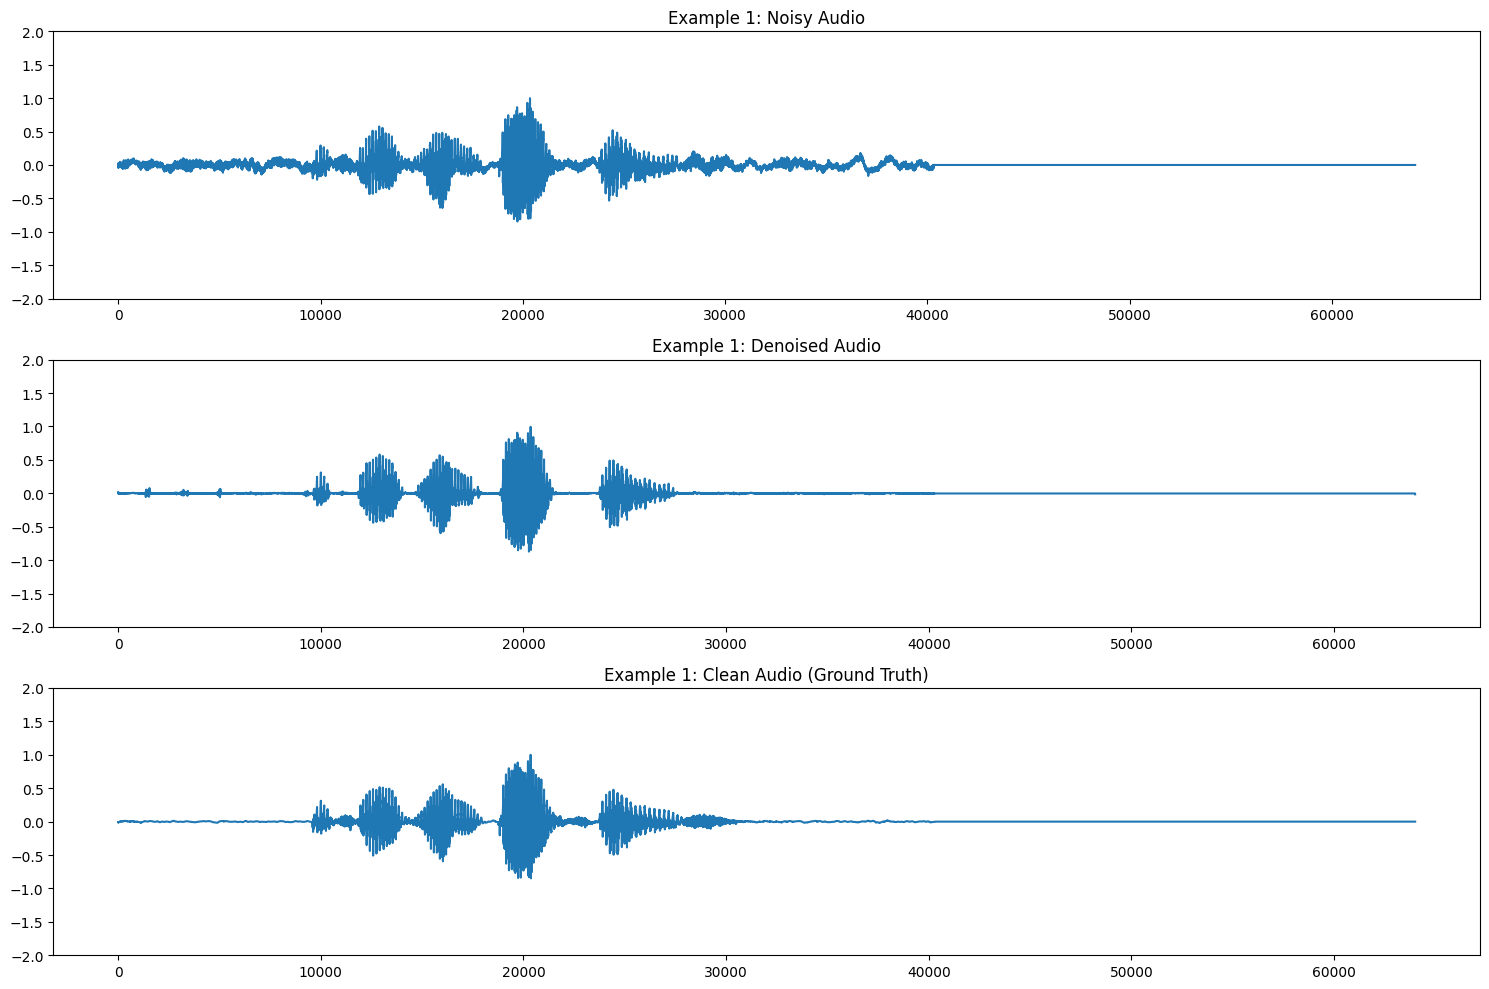


Example 1 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


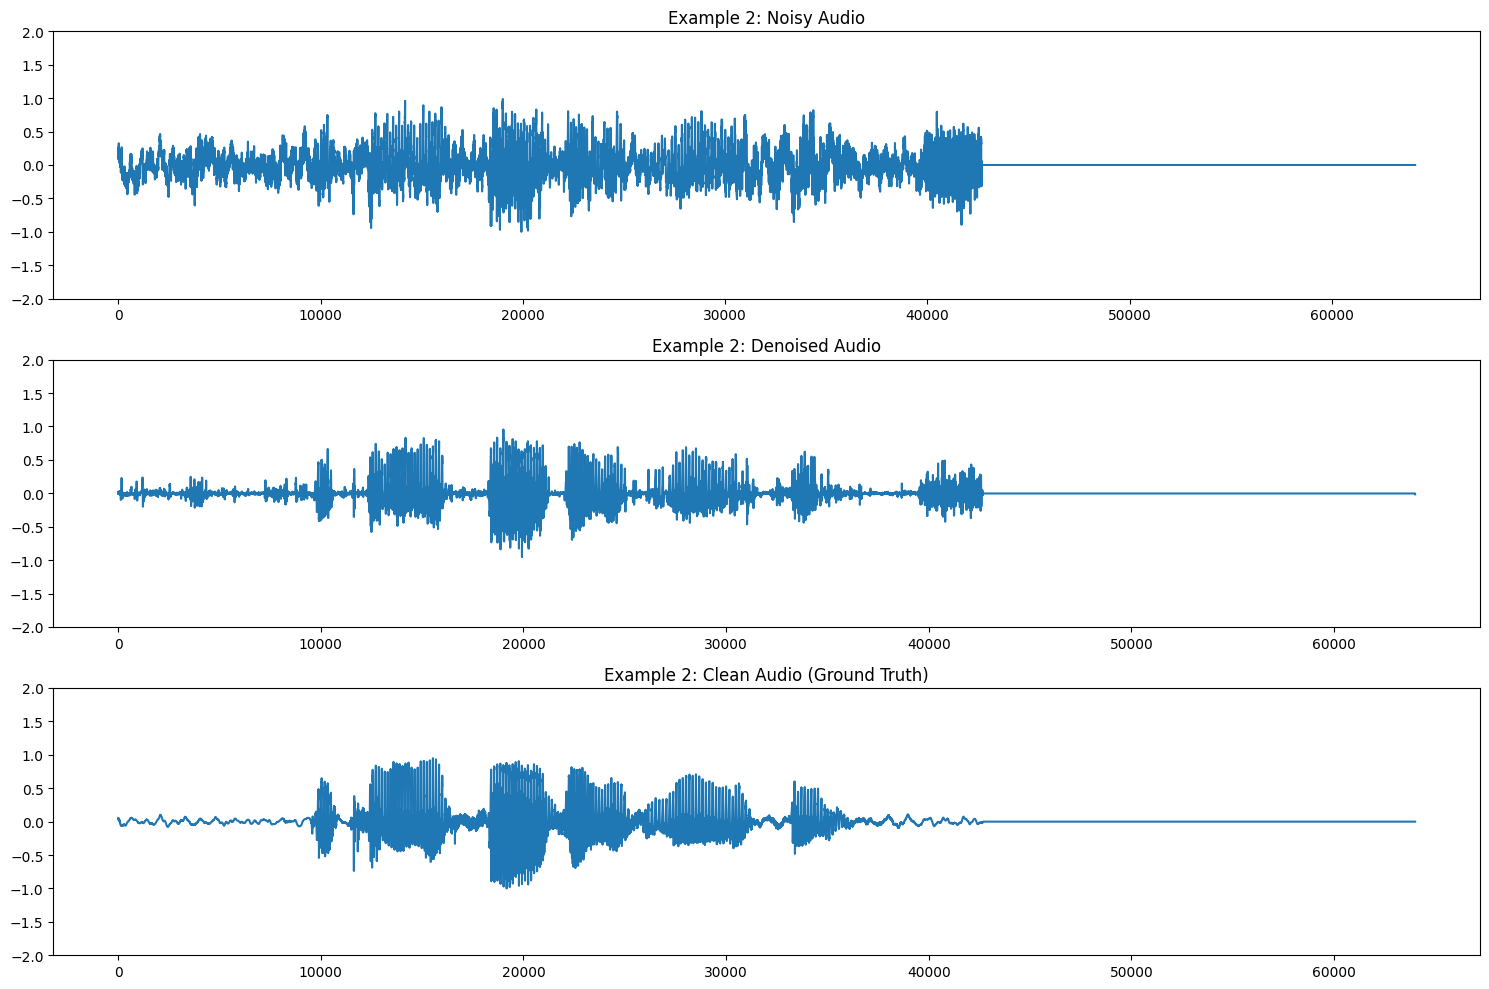


Example 2 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


In [11]:
#all_MSE_channels
#all_model_complete


#load the best model
model.load_state_dict(torch.load('../checkpoints/denoising_model.pth'))
# Run the test
test_results = test_model(model, test_loader, criterion)

Test Loss: 0.000051
Average SNR before denoising: 10.02 dB
Average SNR after denoising: 10.69 dB
Average SNR improvement: 0.68 dB
Average PESQ before denoising: 1.78
Average PESQ after denoising: 1.75
Average STOI before denoising: 0.89
Average STOI after denoising: 0.83


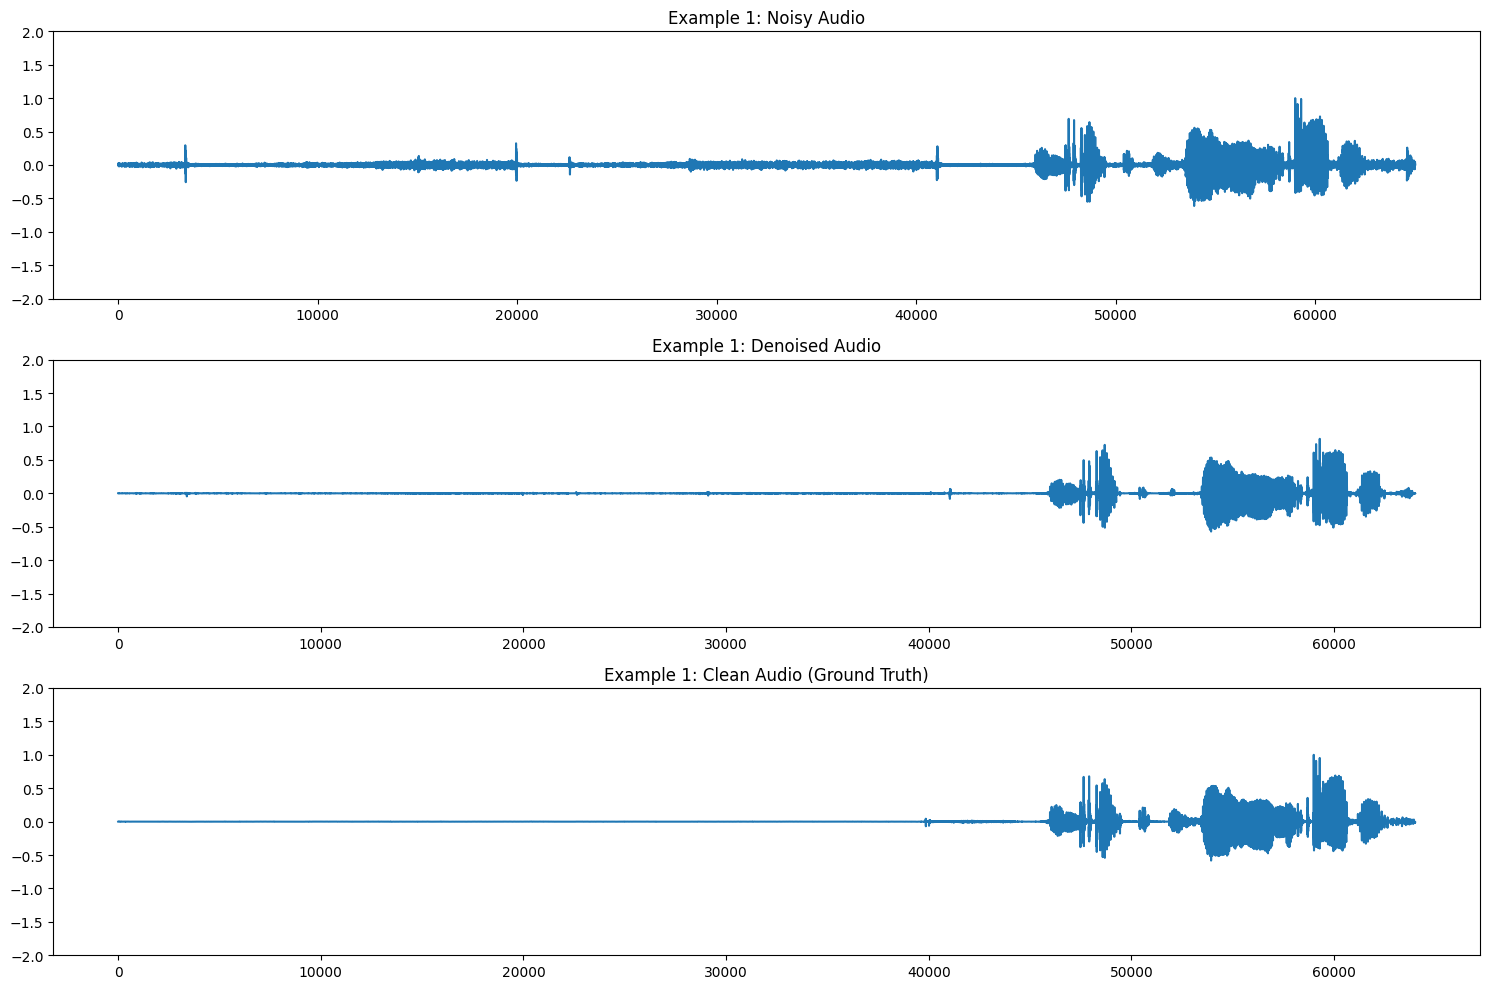


Example 1 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


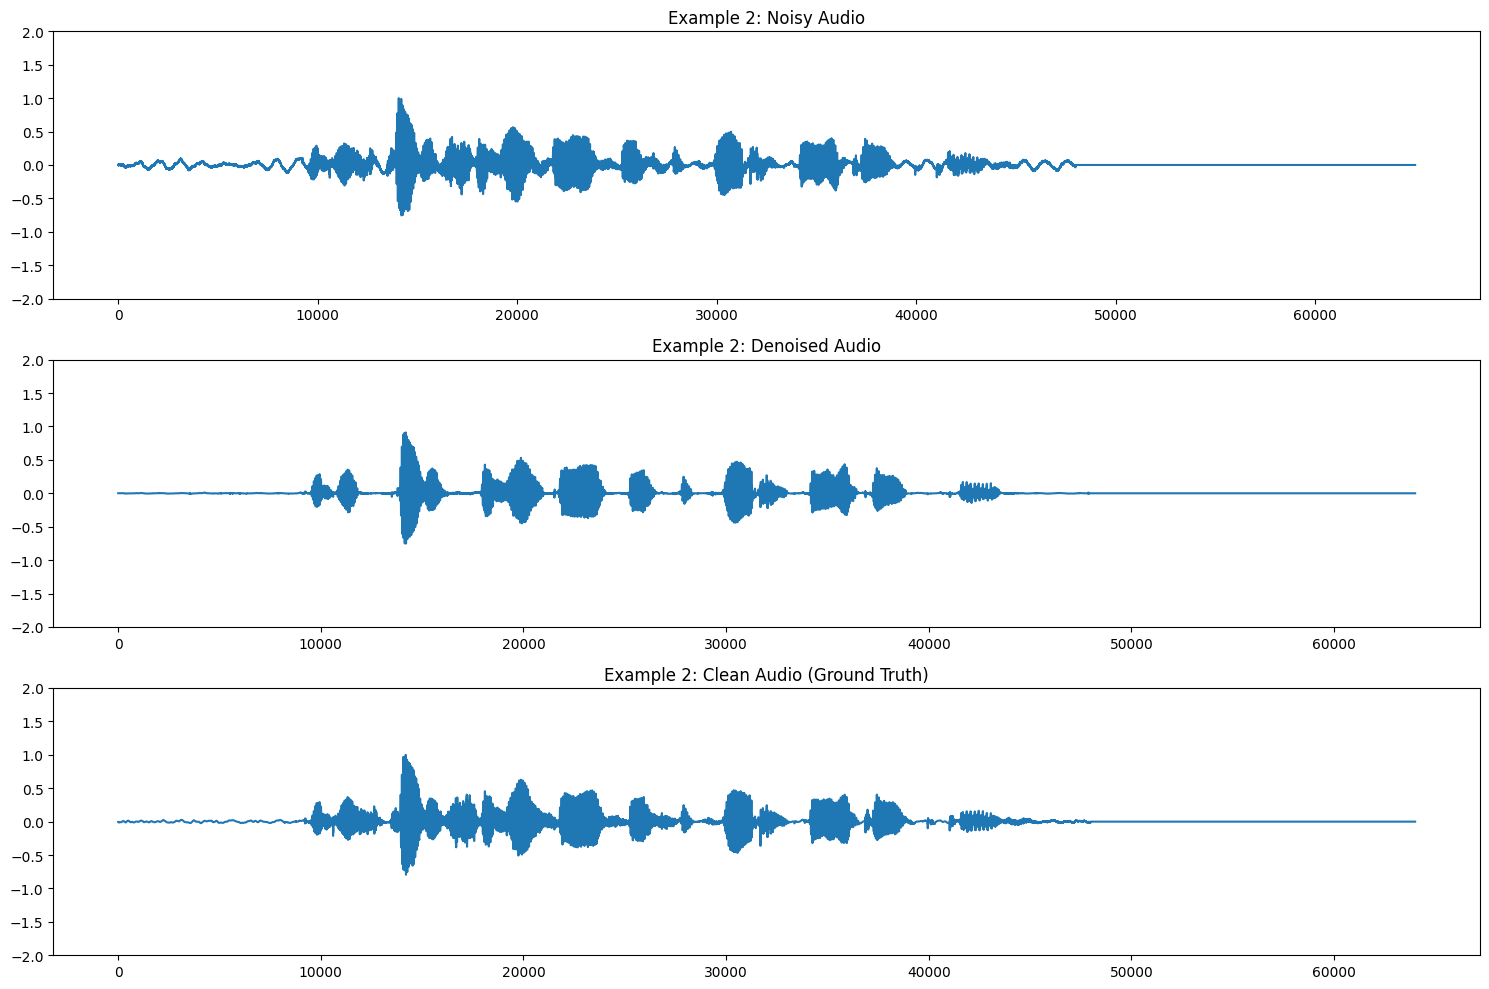


Example 2 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


In [ ]:
#all_MSE_channels
#all_model_complete


#load the best model
model.load_state_dict(torch.load('../checkpoints/all_MSE_channels.pth'))
# Run the test
test_results = test_model(model, test_loader, criterion)